In [ ]:
!pip install gdown


In [ ]:
# Download the train images
!wget http://images.cocodataset.org/zips/train2017.zip -P /content/Dataset/

# Unzip the images
!unzip /content/Dataset/train2017.zip -d /content/Dataset/train2017/

# Download the annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/Dataset/

# Unzip the annotations
!unzip /content/Dataset/annotations_trainval2017.zip -d /content/Dataset/annotations/


Streaming output truncated to the last 5000 lines.
 extracting: /content/Dataset/train2017/train2017/000000249290.jpg  
 extracting: /content/Dataset/train2017/train2017/000000025529.jpg  
 extracting: /content/Dataset/train2017/train2017/000000316928.jpg  
 extracting: /content/Dataset/train2017/train2017/000000337866.jpg  
 extracting: /content/Dataset/train2017/train2017/000000547768.jpg  
 extracting: /content/Dataset/train2017/train2017/000000423162.jpg  
 extracting: /content/Dataset/train2017/train2017/000000224149.jpg  
 extracting: /content/Dataset/train2017/train2017/000000117841.jpg  
 extracting: /content/Dataset/train2017/train2017/000000251660.jpg  
 extracting: /content/Dataset/train2017/train2017/000000110997.jpg  
 extracting: /content/Dataset/train2017/train2017/000000424728.jpg  
 extracting: /content/Dataset/train2017/train2017/000000384745.jpg  
 extracting: /content/Dataset/train2017/train2017/000000475535.jpg  
 extracting: /content/Dataset/train2017/train2017/00

In [ ]:
!pip install spikingjelly

In [ ]:
# Import core libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from spikingjelly.activation_based import neuron, functional
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root
        self.transform = transform
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        self.images = self.coco_data['images']
        self.annotations = {ann['image_id']: ann for ann in self.coco_data['annotations']}

    def __len__(self):
        return min(len(self.images), 5000)  # Limit to 500 images for testing

    def __getitem__(self, index):
        image_info = self.images[index]
        image_path = os.path.join(self.root, image_info['file_name'])
        try:
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = image.resize((32, 32))  # Resize to 32x32
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None

        annotation = self.annotations.get(image_info['id'], {'category_id': 0})
        label = min(annotation['category_id'], 4)  # Map categories to 0–4
        return image, label


In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Grayscale is [1, 32, 32]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = CustomCocoDataset(
    root='/content/Dataset/train2017/train2017',
    annotation_file='/content/Dataset/annotations/annotations/instances_train2017.json',
    transform=data_transform
)

# Filter out corrupted entries
#dataset = [item for item in dataset if item[0] is not None]

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)


In [ ]:
class FakeLIFNode(nn.Module):
    def __init__(self):
        super(FakeLIFNode, self).__init__()

    def forward(self, x):
        # Simple threshold-based spike simulation (no dynamic ops)
        return torch.where(x > 1.0, torch.tensor(1.0, device=x.device), torch.tensor(0.0, device=x.device))


In [ ]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron

class TinySNN_Static(nn.Module):
    def __init__(self, num_classes=5):
        super(TinySNN_Static, self).__init__()
        self.conv = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)  # 4x32x32 grayscale for sample
        self.pool = nn.AvgPool2d(2, 2)  # 4x16x16
        self.lif1 = FakeLIFNode()  # Replaced
        self.fc1 = nn.Linear(4*16*16, 32)
        self.lif2 = FakeLIFNode()  # Replaced
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(self.conv(x))
        x = self.lif1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.lif2(x)
        x = self.fc2(x)
        return x


# Create model
model = TinySNN().to(device)


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler()

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloader:
            if images is None or labels is None:
                continue

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            functional.reset_net(model)  # Reset spiking state

            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")

train_model(model, dataloader, criterion, optimizer)


Epoch [1/2], Loss: 0.8245, Accuracy: 71.54%
Epoch [2/2], Loss: 0.7301, Accuracy: 74.08%


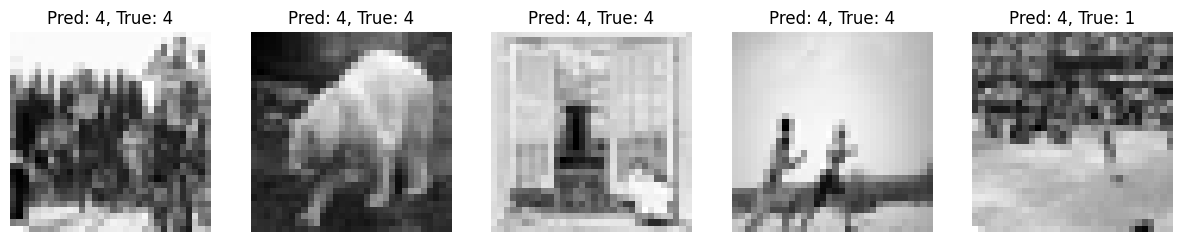

In [ ]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    functional.reset_net(model)

    images, targets = next(iter(dataloader))
    images = images[:num_images].to(device)
    targets = targets[:num_images]

    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Pred: {predictions[i].item()}, True: {targets[i]}")
        axs[i].axis('off')
    plt.show()

visualize_predictions(model, dataloader)


In [ ]:
torch.save(model.state_dict(), 'TinySNN_COCO.pth')
print("Model saved as TinySNN_COCO.pth")


Model saved as TinySNN_COCO.pth


In [ ]:
!pip install onnx


In [ ]:
import torch
import torch.nn as nn
import onnx

# Load model and set to eval on CPU
model = TinySNN_NoReduceMin()
model.eval()
model.cpu()

# Generate dummy input with correct shape
dummy_input = torch.randn(1, 1, 32, 32)  # Format: NCHW

# Export to ONNX (WITHOUT dynamic_axes!)
torch.onnx.export(
    model,
    dummy_input,
    "tinysnn_fixed.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True,
    verbose=False
)


In [ ]:


model = onnx.load("tinysnn_fixed.onnx")
for i in model.graph.input:
    dims = [d.dim_value for d in i.type.tensor_type.shape.dim]
    print(f"{i.name}: shape = {dims}")


input: shape = [1, 1, 32, 32]


In [ ]:
pip install onnxruntime onnxruntime-tools


In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType
quantize_dynamic("tinysnn_clean.onnx", "tinysnn_quant.onnx", weight_type=QuantType.QInt8)


In [ ]:
pip install hls4ml


In [ ]:

!python3 -m onnxsim tinysnn_quant.onnx tinysnn_clean.onnx


Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add            │ 3              │ 3                │
│ AveragePool    │ 1              │ 1                │
│ Cast           │ 6              │ 6                │
│ Constant       │ 13             │ 13               │
│ ConvInteger    │ 1              │ 1                │
│ Div            │ 6              │ 6                │
│ Floor          │ 3              │ 3                │
│ MatMulInteger  │ 2              │ 2                │
│ Mul            │ 6              │ 6                │
│ QuantizeLinear │ 3              │ 3                │
│ ReduceMax      │ 3              │ 3                │
│ ReduceMin      │ 3              │ 3                │
│ Relu           │ 2              │ 2                │
│ Reshape        │ 1              │ 1                │
│ Sub            │

In [ ]:


model = onnx.load("tinysnn_clean.onnx")
op_types = set([node.op_type for node in model.graph.node])
print(op_types)


{'Cast', 'Gemm', 'Constant', 'Conv', 'Not', 'Add', 'Flatten', 'Sub', 'Less', 'AveragePool', 'Div'}


In [ ]:
import hls4ml
import onnx

model = onnx.load("tinysnn_clean.onnx")  # or use "tinysnn_fixed.onnx"
config = hls4ml.utils.config_from_onnx_model(model, backend='Vivado')

config['Model']['Precision'] = 'ap_fixed<16,6>'
config['Model']['ReuseFactor'] = 1
config['Model']['Strategy'] = 'Latency'
config['IOType'] = 'io_parallel'
config['Model']['OutputDir'] = 'tinysnn_fpga_project'
config['Model']['FPGA'] = 'xc7a35tcpg236-1'

hls_model = hls4ml.converters.convert_from_onnx_model(model, hls_config=config)
hls_model.compile()
hls_model.build()


Output layers:  ['/fc2/Gemm']
Input shape: [1, 32, 32]
Topology:


StopIteration: 